# EEG bench mark model

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

# from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMRegressor


Bad key "text.kerning_factor" on line 4 in
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [204]:
feature_names = np.array([])
for line in open('catch_22_feature_names.txt', 'r').readlines():
    feature_names = np.append(feature_names, [line[:-1]])

In [220]:
data_first_half = pd.read_csv('data/data_900.csv', sep=' ', header=None)
data_rest_half = pd.read_csv('data/data_rest.csv', sep=',', header=None)

In [223]:
X = np.concatenate((data_first_half.to_numpy(), data_rest_half.to_numpy()))

In [2]:
X = np.load('data_features.npy')
# X = np.concatenate((X[:, :53], X[:, 57:]), axis=1)
X.shape

(614, 93)

In [3]:
y = np.load('data_label.npy')

In [281]:
np.mean(y)

-0.11074918566775244

In [268]:
corr = np.corrcoef(X, rowvar=0)

In [106]:
corr[np.isnan(corr)] = 0

In [269]:
w, v = np.linalg.eig(corr)

In [270]:
w

array([2.72858044e+01, 1.13342864e+01, 4.53048459e+00, 4.10070633e+00,
       3.92938269e+00, 3.79094042e+00, 3.20452311e+00, 2.55925525e+00,
       2.37892902e+00, 2.18303241e+00, 2.12138890e+00, 2.04855108e+00,
       1.41998906e+00, 1.24856500e+00, 1.20252950e+00, 1.07356650e+00,
       9.70559120e-01, 9.52440078e-01, 9.03457863e-01, 8.37640319e-01,
       7.68632738e-01, 7.30484123e-01, 6.97316336e-01, 6.50017547e-01,
       6.37953677e-01, 5.95454953e-01, 5.89098157e-01, 5.03639281e-01,
       4.84005660e-01, 4.76920380e-01, 4.49468237e-01, 4.34665341e-01,
       4.06963767e-01, 3.76712851e-01, 3.63299400e-01, 3.50538213e-01,
       3.29305976e-01, 3.12936970e-01, 2.95945370e-01, 2.80917494e-01,
       2.58988118e-01, 2.50022028e-01, 2.40392419e-01, 2.43737296e-01,
       2.28809943e-01, 2.17020901e-01, 2.02839590e-01, 2.00965634e-01,
       1.91546637e-01, 1.65483955e-01, 1.78634206e-01, 1.79618589e-01,
       1.59525180e-01, 1.50193995e-01, 1.54765500e-01, 1.41138637e-01,
      

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS, Isomap

pca = TSNE(n_components=2)
transformed = pca.fit_transform(X)
# transformed = pca.transform(X)

In [14]:
np.squeeze(y).shape

(614,)

In [25]:
%matplotlib qt
# pca.explained_variance_ratio_
fig, ax = plt.subplots()

s = ax.scatter(transformed[:,0], transformed[:,1], c=np.squeeze(y))
plt.title("tSNE decomposition of feature space of p2")
ax.add_artist(ax.legend(*s.legend_elements(),
                    loc="upper right", title="Classes"))
# pca.components_.shape

Dog scene for participant 2 is from 328233ms - 549067ms, extract that as test set

In [4]:
dog_start = 328233 // 1000 * 3 # 300Hz to sample
dog_end = 549067 // 1000 * 3

In [5]:
dog_start = 328233 // 1000
dog_end = 549067 // 1000

In [8]:
(dog_end - dog_start)/614

0.35993485342019543

In [283]:
X_train, y_train = np.concatenate((X[:dog_start], X[dog_end:])), np.concatenate((y[:dog_start], y[dog_end:]))
X_test, y_test = X[dog_start:dog_end], y[dog_start:dog_end]
y_train, y_test = np.expand_dims(y_train, axis=1), np.expand_dims(y_test, axis=1)

In [284]:
y_test.shape

(221, 1)

In [285]:
lgbm = TransformedTargetRegressor(
    regressor=LGBMRegressor(), # lightgbm boosted tree
    transformer=s) # using standard scaler

In [286]:
param_grid = {
    "regressor__num_leaves" : [11, 31, 51]
}

In [287]:
grid_search = GridSearchCV(lgbm, param_grid, return_train_score=True, verbose=2, n_jobs=-1)

In [288]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.9s finished


GridSearchCV(estimator=TransformedTargetRegressor(regressor=LGBMRegressor(),
                                                  transformer=StandardScaler()),
             n_jobs=-1, param_grid={'regressor__num_leaves': [11, 31, 51]},
             return_train_score=True, verbose=2)

In [289]:
grid_search.best_score_

-0.36442737989815377

In [179]:
lasso = TransformedTargetRegressor(
    regressor=LassoCV(), # ridge linear regression
    transformer=s) # using standard scaler
cvscore = cross_val_score(lasso, X_train, y_train)

In [180]:
cvscore

array([-1.12251750e-02, -1.27632251e-05, -1.57542914e-03, -2.75336750e-03,
       -1.39504095e-04])

Classification

In [85]:
np.savetxt('features.csv', X, delimiter=',')
np.savetxt('labels.csv', y, delimiter=',')

In [86]:
np.save('X_2.npy', X)
np.save('y_2.npy', y)

array([0.62703583])

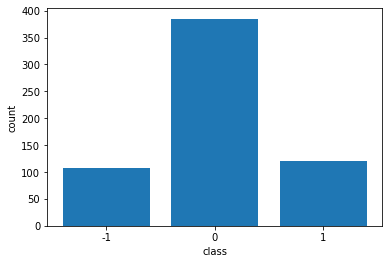

In [16]:
y = np.load('data_label.npy')
s = StandardScaler()
y = s.fit_transform(np.expand_dims(y, axis=1))

y[abs(y) < 0.25] = 0
y[y >= 0.25] = 1
y[y <= -0.25] = -1

plt.xlabel("class")
plt.ylabel("count")
plt.bar(["-1", "0", "1"], [np.sum(y == -1), np.sum(y == 0), np.sum(y == 1)])
sum(abs(y) < 0.25) / y.shape[0]

In [233]:
X_train, y_train = np.concatenate((X[:dog_start], X[dog_end:])), np.concatenate((y[:dog_start], y[dog_end:]))
X_test, y_test = X[dog_start:dog_end], y[dog_start:dog_end]

In [36]:
rfe_validation = RFECV(RandomForestClassifier(), n_features_to_select=30, step=0.5, verbose=2)
rfe_validation.fit(X_train, np.ravel(y_train))

Fitting estimator with 93 features.
Fitting estimator with 47 features.


RFE(estimator=RandomForestClassifier(), n_features_to_select=30, step=0.5,
    verbose=2)

In [37]:
np.remainder(np.where(rfe_validation.ranking_ == 1),22)
feature_names[np.unique(np.remainder(np.where(rfe_validation.ranking_ == 1),22))]

NameError: name 'feature_names' is not defined

In [183]:
forest = RandomForestClassifier()
param_grid = {
    "criterion" : ["gini", "entropy"],
    "max_depth": [10, 100, 1000],
    "min_samples_leaf": [1, 10, 100]
}
grid_search = GridSearchCV(forest, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train[:,rfe_validation.support_], y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    9.9s finished
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 100, 1000],
                         'min_samples_leaf': [1, 10, 100]},
             return_train_score=True, verbose=2)

In [184]:
grid_search.best_score_

0.6615384615384615

In [185]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 100}

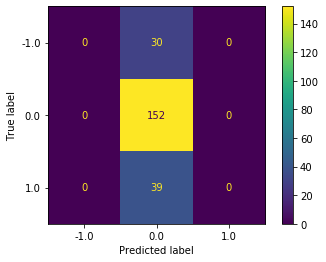

In [186]:
plot_confusion_matrix(grid_search.best_estimator_, X_test[:,rfe_validation.support_], y_test)

In [220]:
from sklearn.linear_model import LogisticRegression
lr = Pipeline([
    ('standardization', StandardScaler()),
    ('lr', LogisticRegression())
])
cv_score = cross_validate(lr, X_train, y_train, return_train_score=True, verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


In [221]:
pd.DataFrame(cv_score)

,fit_time,score_time,test_score,train_score
0,0.129467,0.001106,0.393162,0.626068
1,0.126528,0.001082,0.393162,0.611111
2,0.127543,0.001057,0.307692,0.613248
3,0.132514,0.001068,0.282051,0.658120
4,0.052210,0.000685,0.376068,0.660256


In [222]:
confusion_matrix(y_train, cross_val_predict(lr, X_train, y_train))

/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

array([[ 37,  65,  56],
       [ 62, 112,  73],
       [ 47,  77,  56]])

In [223]:
from sklearn.model_selection import RandomizedSearchCV

knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors" : np.arange(3)
}
grid_search = RandomizedSearchCV(knn, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.4s finished
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': array([0, 1, 2])},
                   return_train_score=True, verbose=2)

In [224]:
pd.DataFrame(grid_search.cv_results_)[["mean_train_score", "mean_test_score"]]

,mean_train_score,mean_test_score
0,NaN,NaN
1,1.000000,0.360684
2,0.688034,0.345299


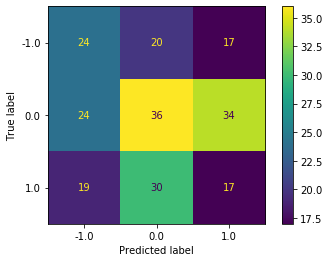

In [225]:
plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)

In [234]:
from sklearn.metrics.pairwise import euclidean_distances

class_1 = X_train[np.squeeze(y_train == 1)]
class_0 = X_train[np.squeeze(y_train == 0)]
class_neg_1 = X_train[np.squeeze(y_train == -1)]

d_1_0 = euclidean_distances(class_neg_1, class_1)

(array([29612., 15884.,  3624.,  1691.,   564.,   216.,   109.,     0.,
           40.,   180.]),
 array([  29738.48959598,  321167.18044616,  612595.87129633,
         904024.56214651, 1195453.25299669, 1486881.94384687,
        1778310.63469705, 2069739.32554723, 2361168.0163974 ,
        2652596.70724758, 2944025.39809776]),
 <a list of 10 Patch objects>)

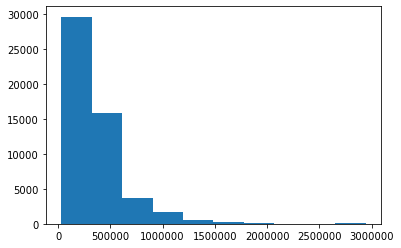

In [235]:
plt.hist(d_1_0.flatten())

In [236]:
d_1_0.max(), d_1_0.min()

(2944025.3980977614, 29738.489595977688)

In [271]:
sum(d_1_0.flatten() == 0.0), class_1.shape[0]

(0, 198)

In [237]:
svc = SVC()
param_grid = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100, 10e5]
}
grid_search = GridSearchCV(svc, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   50.4s finished
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000000.0]},
             return_train_score=True, verbose=2)

In [238]:
pd.DataFrame(grid_search.cv_results_)[["mean_train_score", "mean_test_score", "param_C"]]

,mean_train_score,mean_test_score,param_C
0,0.403419,0.403419,0.001
1,0.403419,0.403419,0.01
2,0.403419,0.403419,0.1
3,0.463675,0.418803,1
4,0.507265,0.400000,10
5,0.573504,0.386325,100
6,0.992735,0.338462,1e+06


In [239]:
grid_search.best_score_

0.4188034188034188

In [240]:
grid_search.best_params_

{'C': 1}

In [241]:
confusion_matrix(y_train, cross_val_predict(grid_search.best_estimator_, X_train, y_train))

/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

array([[ 54,   0, 166],
       [ 39,   0,  90],
       [ 45,   0, 191]])

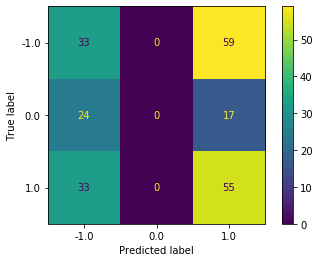

In [243]:
plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)

(array([92.,  0.,  0.,  0.,  0., 41.,  0.,  0.,  0., 88.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

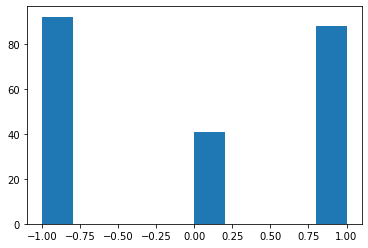

In [242]:
plt.hist(y_test)

In [210]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier((100,100,20,5), max_iter=300).fit(X_train, np.ravel(y_train))
# confusion_matrix(y_train, cross_val_predict(clf, X_train, y_train))
pd.DataFrame(cross_val_score(clf, X_train, np.ravel(y_train)))


/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,0
0,0.666667
1,0.666667
2,0.658120
3,0.658120
4,0.658120


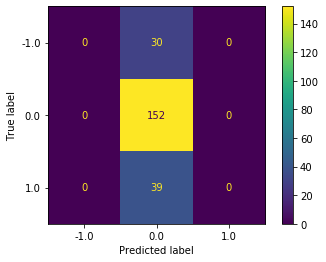

In [211]:
plot_confusion_matrix(clf, X_test, y_test)

Regression on emotion state

In [142]:
y = np.load('data/data_feeltrace_300hz.npy')[:1839]
s = StandardScaler()
y = s.fit_transform(np.expand_dims(y, axis=1))
y.shape

(1839, 1)

In [143]:
X_train, y_train = np.concatenate((X[:dog_start], X[dog_end:])), np.concatenate((y[:dog_start], y[dog_end:]))
X_test, y_test = X[dog_start:dog_end], y[dog_start:dog_end]
# y_train, y_test = np.expand_dims(y_train, axis=1), np.expand_dims(y_test, axis=1)

In [145]:
param_grid = {
    "regressor__num_leaves" : [11, 31, 51]
}
grid_search = GridSearchCV(lgbm, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search

GridSearchCV(estimator=TransformedTargetRegressor(regressor=LGBMRegressor(),
                                                  transformer=StandardScaler()),
             n_jobs=-1, param_grid={'regressor__num_leaves': [11, 31, 51]},
             return_train_score=True, verbose=2)

In [146]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   39.1s finished


GridSearchCV(estimator=TransformedTargetRegressor(regressor=LGBMRegressor(),
                                                  transformer=StandardScaler()),
             n_jobs=-1, param_grid={'regressor__num_leaves': [11, 31, 51]},
             return_train_score=True, verbose=2)

In [147]:
grid_search.best_score_

-0.4181378129032568

Classification on emotion state

In [152]:
y = np.load('data/data_feeltrace_300hz.npy')[:1839]
s = MinMaxScaler((-10, 10))
y = s.fit_transform(np.expand_dims(y, axis=1))
y.shape

(1839, 1)

(array([121.,   0.,   0.,   0.,   0., 539.,   0.,   0.,   0., 146.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

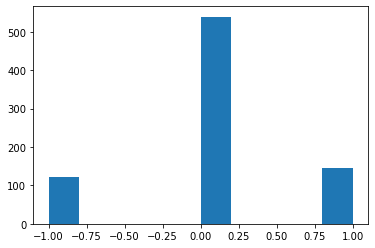

In [212]:
plt.hist(y)

array([0.52854812])

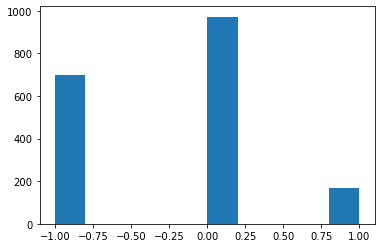

In [155]:
y[abs(y) < (10.0/3)] = 0
y[y >= (10.0/3)] = 1
y[y <= -(10.0/3)] = -1

plt.hist(y)
sum(abs(y) < 0.25) / y.shape[0]

In [156]:
X_train, y_train = np.concatenate((X[:dog_start], X[dog_end:])), np.concatenate((y[:dog_start], y[dog_end:]))
X_test, y_test = X[dog_start:dog_end], y[dog_start:dog_end]

In [158]:
svc = SVC()
param_grid = {
    "C" : [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(svc, param_grid, return_train_score=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.4s finished
/Users/Qianqian/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True, verbose=2)

In [161]:
grid_search.best_score_

0.5340137035701407

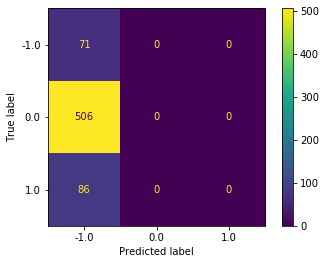

In [166]:
plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test)